Intention of this notebook is to see how the performance of the models varies if the crossvalidation happens on a per protein basis. While it is called *per-protein cross-validation* for legacy reasons, its referenced as *leave-one-protein-out cross-validation* otherwise, because it better reflects its nature.

For this cross-validation procedure the dataset is split as many times into train/test, as there are different wild-type proteins in it (134). For each split, all datapoints, except those related to a single wild-type protein, become the train set, which leaves only "a single protein" (inlcuding its mutants) in the holdout set.

You will find old nomenclature here, in brakets is the current model name.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
print("Check correctnes of locations: ")

print("Folders: ")
data_target_location = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Per_Protein_Crossvalidation/"
print("\t",os.path.isdir(data_target_location))

print("Files: ")
index_T1973_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1973/paper_datasets_T1973/index_xgboost_T1973.csv"
label_T1973_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1973/paper_datasets_T1973/y_label_xgboost_T1973.csv"

X_paper_T1973_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1973/paper_datasets_T1973/X_paper_xgboost_T1973.csv"
X_cnn_rep_all_03_T1973_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1973/cnn_rep_sampler_T1973/sequence_cnn_rep_all_default_03.csv"
X_cnn_rep_mut_03_T1973_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1973/cnn_rep_sampler_T1973/sequence_cnn_rep_mut_default_03.csv"

print("\t",os.path.isfile(index_T1973_loc))
print("\t",os.path.isfile(label_T1973_loc))
print("\t",os.path.isfile(X_cnn_rep_all_03_T1973_loc))
print("\t",os.path.isfile(X_cnn_rep_all_03_T1973_loc))
print("\t",os.path.isfile(X_cnn_rep_mut_03_T1973_loc))

Check correctnes of locations: 
Folders: 
	 True
Files: 
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

## Notebook Setup Local Runtime

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

import matplotlib.pyplot as plt
#import seaborn as sns

import time
import datetime

In [0]:
import xgboost as xgb
from bayes_opt import BayesianOptimization

In [0]:
print("Check correctnes of locations: ")

print("Folders: ")
data_target_location = "Users/Whatever/Desktop/Google_Colab_Local/Per_Protein_Crossvalidation/"
print("\t",os.path.isdir(data_target_location))

print("Files: ")
index_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/paper_datasets_T1973/index_xgboost_T1973.csv"
label_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/paper_datasets_T1973/y_label_xgboost_T1973.csv"

X_paper_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/paper_datasets_T1973/X_paper_xgboost_T1973.csv"
X_cnn_rep_all_03_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/cnn_rep_sampler_T1973/sequence_cnn_rep_all_default_03.csv"
X_cnn_rep_mut_03_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/cnn_rep_sampler_T1973/sequence_cnn_rep_mut_default_03.csv"
X_ALG_Cart_tiE_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/paper_datasets_T1973/X_ALG_Cart-tiE_xgboost_T1973.csv"
X_ALG_T1973_loc = "Users/Whatever/Desktop/Google_Colab_Local/T1973/paper_datasets_T1973/X_ALG_xgboost_T1973.csv"

print("\t",os.path.isfile(index_T1973_loc))
print("\t",os.path.isfile(label_T1973_loc))
print("\t",os.path.isfile(X_cnn_rep_all_03_T1973_loc))
print("\t",os.path.isfile(X_cnn_rep_all_03_T1973_loc))
print("\t",os.path.isfile(X_cnn_rep_mut_03_T1973_loc))
print("\t",os.path.isfile(X_ALG_Cart_tiE_T1973_loc))
print("\t",os.path.isfile(X_ALG_T1973_loc))

Check correctnes of locations: 
Folders: 
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True


## Prepare Data

In [0]:
#Just load data
y_label = pd.read_csv(label_T1973_loc)
y_index = pd.read_csv(index_T1973_loc)
y_index_cleaned = [x.split("@")[0].split("_")[0] for x in y_index.Mutation.values] #same wildtype protein => same name //disregard extra single mutations
X_paper_T1973 = pd.read_csv(X_paper_T1973_loc)
X_cnn_rep_all_03_T1973 = pd.read_csv(X_cnn_rep_all_03_T1973_loc).drop(["Mutation"],axis=1) #somehow mutation is in there
X_cnn_rep_mut_03_T1973 = pd.read_csv(X_cnn_rep_mut_03_T1973_loc)
X_ALG_Cart_tiE_T1973 = pd.read_csv(X_ALG_Cart_tiE_T1973_loc)
X_ALG_T1973 = pd.read_csv(X_ALG_T1973_loc)

In [0]:
unique, counts = np.unique(y_index_cleaned, return_counts=True) #to calculate the weighted MAE

In [0]:
unique

In [0]:
counts

array([  5,   6,   1,   4,   1,   7,  25,   1,  18,   2,   1,  35,  15,
         2,   1,  37,   2,   2,   3,  23,   5,   5,  27,   3,  10,  12,
         2,   1,   2,   1, 129,   4,  23,   4,   4,   2,  33,   1,  53,
         2,   1,   1,  28,  16,   3,   7,   3,   2,   2,   3,   8,  14,
         1,   2,   4,   3,   3,   3,   1,   1,  43,   9,   3,   3, 184,
        15,  35,   1, 131,  99,   3,   5,   6,   4,  10,  13,  30,   9,
         9,   6,   1,  33,  15,   2,   1,   3,  49,   5,  17,   9,   5,
         3,   1,   1,  21,   2,   9,  40,  38,   1,   1,   2,   3,   4,
         2,   3,   8,   2,  18,   2,   1,   1,   1,   5,   3,   1, 106,
         1,  70,   8,   3,   2,   6,   2,  12,   4,   7,   4,  44,   3,
         4,  15,  35,  96], dtype=int64)

In [0]:
len(set(y_index_cleaned))

134

In [0]:
X_paper_T1973.loc[np.array(y_index_cleaned)=="1AQH"]

alpha_diff  alpha_first  alpha_second  aromatic_diff  aromatic_first  \
11       -0.29         1.35          1.06              1               0   
12        0.06         1.11          1.17              0               0   
13       -0.15         1.32          1.17              0               0   
14        0.40         0.77          1.17              0               0   
15        0.12         0.77          0.89              0               0   
16        0.18         1.17          1.35              0               0   
17        0.12         0.89          1.01              1               0   

    aromatic_second  beta_diff  beta_first  beta_second  branched_diff  \
11                1       0.58        0.72         1.30              0   
12                0       0.08        0.83         0.91              0   
13                0      -0.19        1.10         0.91             -1   
14                0       0.28        0.63         0.91              0   
15                0      -0.08        0.63         0.55              0   
16                0      -0.19        0.91         0.72              0   
17                1      -0.43        1.86         1.43             -1   

         ...        r_bioluminate_delta_stability_packing  \
11       ...                                -1.566383e+00   
12       ...                                -1.792414e+00   
13       ...                                -6.990317e-03   
14       ...                                 1.465648e-04   
15       ...                                 7.262000e-01   
16       ...                                 0.000000e+00   
17       ...                                -1.107030e-08   

    r_bioluminate_delta_stability_reference  \
11                                   -16.05   
12                                    33.96   
13                                    33.99   
14                                   -18.13   
15                                    -3.11   
16                                    -1.79   
17                                     6.44   

    r_bioluminate_delta_stability_selfcont  \
11                                0.000000   
12                                0.000000   
13                                0.000000   
14                                2.459943   
15                                0.101785   
16                                0.000000   
17                                0.000000   

    r_bioluminate_delta_stability_solv_gb  \
11                              79.637072   
12                              23.033676   
13                              41.380661   
14                              10.901502   
15                             -60.081112   
16                            -133.864087   
17                              -0.315105   

    r_bioluminate_delta_stability_solv_sa  r_bioluminate_delta_stability_vdw  \
11                                      0                          -3.259749   
12                                      0                          -0.801573   
13                                      0                          -4.115861   
14                                      0                          -5.241242   
15                                      0                           0.297613   
16                                      0                           2.609374   
17                                      0                           1.260154   

    totalarea  vdw_vol_diff  vdw_vol_first  vdw_vol_second  
11    241.761          34.6           40.2            74.8  
12    389.367          15.8           61.5            77.3  
13    312.302          32.9           44.4            77.3  
14    277.016          44.6           32.7            77.3  
15    201.946          -2.7           32.7            30.0  
16    354.243         -37.1           77.3            40.2  
17    272.643          22.0           34.1            56.1  

[7 rows x 158 columns]

In [0]:
y_index.head(10)

Mutation
0  1AKY@A@I213F
1  1AKY@A@N169D
2   1AKY@A@Q48E
3  1AKY@A@T110H
4   1AKY@A@T77H
5    1AKY@A@V8I
6   1AM7@A@H31D
7   1ANK@A@D84H
8   1ANK@A@F86L
9   1ANK@A@G85V

In [0]:
X_cnn_rep_mut_03_T1973.head()

mut_rep_0  mut_rep_1  mut_rep_2  mut_rep_3  mut_rep_4  mut_rep_5  \
0   3.554784   3.280347   3.196928    2.98941   3.001729   5.001732   
1   3.554784   3.280347   3.618918    2.98941   3.001729   5.001732   
2   3.554784   3.280347   3.618918    2.98941   3.001729   5.001732   
3   3.554784   3.280347   3.618918    2.98941   3.001729   5.001732   
4   3.554784   3.280347   3.618918    2.98941   3.001729   5.001732   

   mut_rep_6  mut_rep_7  mut_rep_8  mut_rep_9     ...       mut_rep_758  \
0   2.902748    2.11822   3.150281   3.451558     ...          3.359161   
1   2.902748    2.11822   3.150281   3.451558     ...          3.357924   
2   2.902748    1.81807   3.150281   3.451558     ...          3.359161   
3   2.902748    2.11822   2.561329   3.451558     ...          3.359161   
4   2.902748    2.11822   3.150281   3.451558     ...          3.359161   

   mut_rep_759  mut_rep_760  mut_rep_761  mut_rep_762  mut_rep_763  \
0     1.316831     0.000000     1.055476     1.873763     2.145716   
1     1.316831     0.000000     1.055476     1.873763     2.145716   
2     1.316831     0.000000     1.055476     1.873763     2.185869   
3     1.316831     0.068523     0.952350     1.883678     2.145716   
4     1.327890     0.000000     1.055476     1.793253     2.145716   

   mut_rep_764  mut_rep_765  mut_rep_766  mut_rep_767  
0     2.019033     3.575753     3.583557     1.999178  
1     1.951526     3.575753     3.789693     1.999178  
2     2.091188     3.575753     3.789693     1.999178  
3     1.976812     3.575753     3.789693     2.039857  
4     1.976812     3.814830     3.789693     2.302211  

[5 rows x 768 columns]

## Supplementary functions

In [0]:
def nested_k_fold_per_proteincrossvalidation(data_x, data_y, protein_label, eval_metric="mae", scale_label=False, inner_fold=3, bayes_init_points=15, bayes_iterations=10, bayes_acquisition_function='ei', k_fold_seed=42375):  
  print("Evaluation metric: ", eval_metric)
  print("Inner folds: ", inner_fold)
  print("Bayesian init points: ", bayes_init_points)
  print("Bayesian iterations: ", bayes_iterations)
  print("Bayes acquisition function: ", bayes_acquisition_function)

  # Variable for xgb_evalutate, unfortunately cannot be a direct argument
  bayesian_training_data = None
  # Supplementary function for hyperparameter tuning. Corresponds in essense to inner cross validation.
  def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, eta):
      params = {'eval_metric': eval_metric,
                'objective':'reg:linear',
                'tree_method': 'gpu_hist',
                'max_depth': int(max_depth),
                'eta': eta,
                'gamma': gamma,
                'colsample_bytree': colsample_bytree,
                'subsample': subsample}
      # This corresponds to the inner cross validation cycle for hyperparameter tuning:
      cv_result = xgb.cv(params, bayesian_training_data, num_boost_round=100, nfold=inner_fold)    
      # Bayesian optimization only knows how to maximize, not minimize, thus negate score:
      return -1.0 * cv_result['test-mae-mean'].iloc[-1]
    
  # Bounds for the bayesian optimization
  bay_bounds={'eta': (0.01, 0.3),
              'max_depth': (5, 10), 
              'gamma': (0.0, 1.0),
              'colsample_bytree': (0.5, 1.0),
              'subsample': (0.7, 1.0)}
  
  #saves result for each outer cross val
  protein_label = np.array(protein_label) 
  proteins = np.sort(np.unique(protein_label)) #this will determine the number of folds, since this is protein based cross-val
  print("Totoal Folds: ",len(proteins))

  scores_mae = [] 
  scores_rmse = []
  best_parameters = []
  
  total_fold_counter = 0

  # Main loop for trials and outer outer cross_val
  for curr_protein in proteins:
    #Measure runtime
    start_time = time.time()
    
    # Print current status
    total_fold_counter += 1
    print("Fold number: {}, Protein: {}".format(total_fold_counter,curr_protein))
    
    # Calculate current indices
    train_index = protein_label != curr_protein
    test_index = protein_label == curr_protein
    
    # Select current train and test data
    X_train, X_test = data_x.loc[train_index], data_x.loc[test_index]
    y_train, y_test = data_y.loc[train_index], data_y.loc[test_index]
    
    # Scale target label, if requested
    standard_scaler = preprocessing.StandardScaler()
    if scale_label:
      y_train = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage
    
    # Prepare data for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # Bayesian optimize in 5 fold cross validation
    xgb_bo = BayesianOptimization(f=xgb_evaluate, 
                                  pbounds=bay_bounds,
                                  random_state=((total_fold_counter*k_fold_seed)%1000))
    bayesian_training_data = dtrain
    xgb_bo.maximize(init_points=bayes_init_points, n_iter=bayes_iterations, acq=bayes_acquisition_function) #default: 20,20,'ei'
    
    # Extract optimal parameters
    params_opt = xgb_bo.max['params']
    best_parameters.append(params_opt) #save best parameters
    params_opt['max_depth'] = int(params_opt['max_depth'])
    params_opt['eval_metric'] = eval_metric
    params_opt['objective'] = 'reg:linear'
    params_opt['tree_method'] = 'gpu_hist'
    
    # Train a new model with the best parameters from the search
    model = xgb.train(params_opt, dtrain, num_boost_round=1000)

    # Predict on testing set
    y_pred = model.predict(dtest)
    if scale_label:
      y_pred = standard_scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Report testing and training scores
    scores_mae.append(mean_absolute_error(y_test, y_pred))
    scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE: ", scores_mae[-1], " RMSE: ",scores_rmse[-1], " Runtime: ", str(datetime.timedelta(seconds=(time.time()-start_time))))
  
  print()
  results = pd.DataFrame(best_parameters)
  results["scores_mae"] = scores_mae
  results["scores_rmse"] = scores_rmse
  results["protein"] = proteins
  return results

In [0]:
def avg_pred(data_x, data_y, protein_label, eval_metric="mae", scale_label=False, k_fold_seed=42375):  
  print("Evaluation metric: ", eval_metric)
  
  #saves result for each outer cross val
  protein_label = np.array(protein_label) 
  proteins = np.sort(np.unique(protein_label)) #this will determine the number of folds, since this is protein based cross-val
  print("Totoal Folds: ",len(proteins))

  scores_mae = [] 
  scores_rmse = []
  
  total_fold_counter = 0

  # Main loop for trials and outer outer cross_val
  for curr_protein in proteins:
    #Measure runtime
    start_time = time.time()
    
    # Print current status
    total_fold_counter += 1
    print("Fold number: {}, Protein: {}".format(total_fold_counter,curr_protein))
    
    # Calculate current indices
    train_index = protein_label != curr_protein
    test_index = protein_label == curr_protein
    
    # Select current train and test data
    X_train, X_test = data_x.loc[train_index], data_x.loc[test_index]
    y_train, y_test = data_y.loc[train_index], data_y.loc[test_index]
    
    # Scale target label, if requested
    standard_scaler = preprocessing.StandardScaler()
    if scale_label:
      y_train = standard_scaler.fit_transform(y_train.reshape(-1, 1)).reshape((len(y_train))) #only fit on y_train to prevent information leakage
    
    # Predict on testing set
    y_pred = np.ones(len(y_test)) * np.mean(y_train).values
    if scale_label:
      y_pred = standard_scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Report testing and training scores
    scores_mae.append(mean_absolute_error(y_test, y_pred))
    scores_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE: ", scores_mae[-1], " RMSE: ",scores_rmse[-1], " Runtime: ", str(datetime.timedelta(seconds=(time.time()-start_time))))
  
  print()
  results = pd.DataFrame()
  results["scores_mae"] = scores_mae
  results["scores_rmse"] = scores_rmse
  results["protein"] = proteins
  return results

In [0]:
def plot_results_bar_err(results_df, std_df, title, saveloc, fig_size=(7,6), fig_lim=(2,6)):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(yerr=std_df, ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7, error_kw=dict(ecolor='dimgrey', lw=1.5, capsize=4, capthick=1.5))
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

In [0]:
def calc_weighted_std(measures, counts, mean):
  result = 0
  for m, c in zip(measures,counts):
    result += c * ((m-mean)**2)
  result /= counts.sum()
  result = result ** (1/2)
  return result  

## Evaluate different models (based on source data)

### Model paper ppcv: (S_E)

In [0]:
model_paper_results = nested_k_fold_per_proteincrossvalidation(X_paper_T1973, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Inner folds:  3
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.984    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.145    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.124    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.368    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.151    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.925    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.061    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.969    |  0.8363   |  0.1261   |  0.9

In [0]:
model_paper_results

colsample_bytree       eta eval_metric     gamma  max_depth   objective  \
0            0.825265  0.077492         mae  0.324713          8  reg:linear   
1            0.514375  0.102747         mae  0.181222          6  reg:linear   
2            0.596137  0.070909         mae  0.244598          5  reg:linear   
3            0.586535  0.040438         mae  0.243991          8  reg:linear   
4            0.605365  0.056826         mae  0.414122          9  reg:linear   
5            0.607390  0.089072         mae  0.357340          8  reg:linear   
6            0.928401  0.132985         mae  0.217963          5  reg:linear   
7            0.835319  0.071011         mae  0.128926          6  reg:linear   
8            0.825265  0.077492         mae  0.324713          8  reg:linear   
9            0.784251  0.070476         mae  0.393912          9  reg:linear   
10           0.596137  0.070909         mae  0.244598          5  reg:linear   
11           0.586535  0.040438         mae  0.243991          8  reg:linear   
12           0.548411  0.042547         mae  0.975458          6  reg:linear   
13           0.891300  0.083646         mae  0.585427          7  reg:linear   
14           0.611662  0.063494         mae  0.370601          9  reg:linear   
15           0.835319  0.071011         mae  0.128926          6  reg:linear   
16           0.825265  0.077492         mae  0.324713          8  reg:linear   
17           0.514375  0.102747         mae  0.181222          6  reg:linear   
18           0.596137  0.070909         mae  0.244598          5  reg:linear   
19           0.586535  0.040438         mae  0.243991          8  reg:linear   
20           0.605365  0.056826         mae  0.414122          9  reg:linear   
21           0.891300  0.083646         mae  0.585427          7  reg:linear   
22           0.511630  0.139122         mae  0.450974          7  reg:linear   
23           0.835319  0.071011         mae  0.128926          6  reg:linear   
24           0.825265  0.077492         mae  0.324713          8  reg:linear   
25           0.514375  0.102747         mae  0.181222          6  reg:linear   
26           0.667982  0.050837         mae  0.891442          5  reg:linear   
27           0.640035  0.083311         mae  0.437719          8  reg:linear   
28           0.605365  0.056826         mae  0.414122          9  reg:linear   
29           0.607390  0.089072         mae  0.357340          8  reg:linear   
..                ...       ...         ...       ...        ...         ...   
104          0.825265  0.077492         mae  0.324713          8  reg:linear   
105          0.550706  0.063112         mae  0.638675          8  reg:linear   
106          0.822126  0.097899         mae  0.141395          7  reg:linear   
107          0.640035  0.083311         mae  0.437719          8  reg:linear   
108          0.605365  0.056826         mae  0.414122          9  reg:linear   
109          0.752707  0.044341         mae  0.278652          8  reg:linear   
110          0.928401  0.132985         mae  0.217963          5  reg:linear   
111          0.835319  0.071011         mae  0.128926          6  reg:linear   
112          0.601588  0.033835         mae  0.053701          7  reg:linear   
113          0.514375  0.102747         mae  0.181222          6  reg:linear   
114          0.596137  0.070909         mae  0.244598          5  reg:linear   
115          0.696210  0.154152         mae  0.332149          6  reg:linear   
116          0.647469  0.084040         mae  0.220502          9  reg:linear   
117          0.942079  0.111708         mae  0.194156          5  reg:linear   
118          0.618654  0.099362         mae  0.080101          9  reg:linear   
119          0.819961  0.051572         mae  0.944669          7  reg:linear   
120          0.601588  0.033835         mae  0.053701          7  reg:linear   
121          0.550706  0.063112         mae  0.638675          8  reg:linear   
122  

In [0]:
model_paper_results.describe()

colsample_bytree         eta       gamma   max_depth   subsample  \
count        134.000000  134.000000  134.000000  134.000000  134.000000   
mean           0.691819    0.073771    0.391222    7.141791    0.838945   
std            0.136105    0.029340    0.252522    1.344177    0.074684   
min            0.511630    0.030558    0.007143    5.000000    0.700000   
25%            0.596137    0.056826    0.236535    6.000000    0.799472   
50%            0.624958    0.070909    0.324713    7.000000    0.824399   
75%            0.825265    0.083646    0.545862    8.000000    0.892402   
max            1.000000    0.224561    0.975458    9.000000    0.996978   

       scores_mae  scores_rmse  
count  134.000000   134.000000  
mean     4.036521     4.652058  
std      2.600242     2.786744  
min      0.019424     0.019424  
25%      2.266639     2.768041  
50%      3.523560     4.084186  
75%      5.235333     6.224659  
max     15.651287    15.853417

In [0]:
model_paper_results.to_csv(data_target_location+"results_paper_xgboost_T1973_ppcv.csv")

In [0]:
model_paper_results = pd.read_csv(data_target_location+"results_paper_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_paper_results["scores_mae"]*counts)/len(X_paper_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_paper_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

3.6130589506614204
1.8538583747657709


In [0]:
weighted_rmse = np.sum(model_paper_results["scores_rmse"]*counts)/len(X_paper_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_paper_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

4.482813606726061
1.9925575546153285


### Model cnn rep (A3)

In [0]:
model_cnn_rep_all_results = nested_k_fold_per_proteincrossvalidation(X_cnn_rep_all_03_T1973, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Inner folds:  3
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.258    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.348    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.4      |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.555    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.379    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.212    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.345    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.23     |  0.8363   |  0.1261   |  0.9

In [0]:
model_cnn_rep_all_results

colsample_bytree       eta eval_metric     gamma  max_depth   objective  \
0            0.825265  0.077492         mae  0.324713          8  reg:linear   
1            0.550706  0.063112         mae  0.638675          8  reg:linear   
2            0.822126  0.097899         mae  0.141395          7  reg:linear   
3            0.640035  0.083311         mae  0.437719          8  reg:linear   
4            0.605365  0.056826         mae  0.414122          9  reg:linear   
5            0.607390  0.089072         mae  0.357340          8  reg:linear   
6            0.611662  0.063494         mae  0.370601          9  reg:linear   
7            0.835319  0.071011         mae  0.128926          6  reg:linear   
8            0.825265  0.077492         mae  0.324713          8  reg:linear   
9            0.550706  0.063112         mae  0.638675          8  reg:linear   
10           0.822126  0.097899         mae  0.141395          7  reg:linear   
11           0.795632  0.070530         mae  0.782172          9  reg:linear   
12           0.647469  0.084040         mae  0.220502          9  reg:linear   
13           0.752707  0.044341         mae  0.278652          8  reg:linear   
14           0.611662  0.063494         mae  0.370601          9  reg:linear   
15           0.822947  0.136900         mae  0.891773          9  reg:linear   
16           0.706322  0.154447         mae  0.290220          8  reg:linear   
17           0.550706  0.063112         mae  0.638675          8  reg:linear   
18           0.990882  0.092901         mae  0.979590          9  reg:linear   
19           0.640035  0.083311         mae  0.437719          8  reg:linear   
20           0.972196  0.137347         mae  0.020533          6  reg:linear   
21           0.663337  0.121488         mae  0.473057          8  reg:linear   
22           0.513764  0.142896         mae  0.211589          7  reg:linear   
23           0.819961  0.051572         mae  0.944669          7  reg:linear   
24           0.825265  0.077492         mae  0.324713          8  reg:linear   
25           0.784251  0.070476         mae  0.393912          9  reg:linear   
26           0.552428  0.162371         mae  0.284066          8  reg:linear   
27           0.586535  0.040438         mae  0.243991          8  reg:linear   
28           0.605365  0.056826         mae  0.414122          9  reg:linear   
29           0.607390  0.089072         mae  0.357340          8  reg:linear   
..                ...       ...         ...       ...        ...         ...   
104          0.891733  0.146587         mae  0.420299          8  reg:linear   
105          0.784251  0.070476         mae  0.393912          9  reg:linear   
106          0.990882  0.092901         mae  0.979590          9  reg:linear   
107          0.795632  0.070530         mae  0.782172          9  reg:linear   
108          0.605365  0.056826         mae  0.414122          9  reg:linear   
109          0.607390  0.089072         mae  0.357340          8  reg:linear   
110          0.618654  0.099362         mae  0.080101          9  reg:linear   
111          0.819961  0.051572         mae  0.944669          7  reg:linear   
112          0.825265  0.077492         mae  0.324713          8  reg:linear   
113          0.784251  0.070476         mae  0.393912          9  reg:linear   
114          0.990882  0.092901         mae  0.979590          9  reg:linear   
115          0.586535  0.040438         mae  0.243991          8  reg:linear   
116          0.605365  0.056826         mae  0.414122          9  reg:linear   
117          0.607390  0.089072         mae  0.357340          8  reg:linear   
118          0.631261  0.118135         mae  0.052595          6  reg:linear   
119          0.819961  0.051572         mae  0.944669          7  reg:linear   
120          0.825265  0.077492         mae  0.324713          8  reg:linear   
121          0.784251  0.070476         mae  0.393912          9  reg:linear   
122  

In [0]:
model_cnn_rep_all_results.describe()

colsample_bytree         eta       gamma   max_depth   subsample  \
count        134.000000  134.000000  134.000000  134.000000  134.000000   
mean           0.720813    0.084367    0.495958    8.156716    0.858184   
std            0.132219    0.030564    0.276891    0.916470    0.069776   
min            0.513764    0.030529    0.020533    5.000000    0.700936   
25%            0.605871    0.063112    0.324713    8.000000    0.809113   
50%            0.729514    0.077492    0.414122    8.000000    0.851849   
75%            0.822126    0.092901    0.782172    9.000000    0.906830   
max            0.990882    0.162371    0.988374    9.000000    1.000000   

       scores_mae  scores_rmse  
count  134.000000   134.000000  
mean     4.713231     5.258389  
std      2.906374     3.023606  
min      0.100895     0.100895  
25%      2.342826     2.814712  
50%      4.275064     5.101585  
75%      6.107675     7.079963  
max     13.505624    13.666389

In [0]:
model_cnn_rep_all_results.to_csv(data_target_location+"results_cnn_rep_all_xgboost_T1973_ppcv.csv")

In [0]:
model_cnn_rep_all_results = pd.read_csv(data_target_location+"results_cnn_rep_all_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_cnn_rep_all_results["scores_mae"]*counts)/len(X_cnn_rep_all_03_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_cnn_rep_all_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

4.234991462645863
1.9601433562090178


In [0]:
weighted_rmse = np.sum(model_cnn_rep_all_results["scores_rmse"]*counts)/len(X_cnn_rep_all_03_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_cnn_rep_all_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

5.104671438269491
2.133625592264799


### Model cnn_rep mut ppcv: (M3)

In [0]:
model_cnn_rep_mut_results = nested_k_fold_per_proteincrossvalidation(X_cnn_rep_mut_03_T1973, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Inner folds:  3
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.286    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.407    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.415    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.576    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.408    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.248    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.31     |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.286    |  0.8363   |  0.1261   |  0.9

In [0]:
model_cnn_rep_mut_results

colsample_bytree       eta eval_metric     gamma  max_depth   objective  \
0            0.706322  0.154447         mae  0.290220          8  reg:linear   
1            0.550706  0.063112         mae  0.638675          8  reg:linear   
2            0.990882  0.092901         mae  0.979590          9  reg:linear   
3            0.795632  0.070530         mae  0.782172          9  reg:linear   
4            0.605365  0.056826         mae  0.414122          9  reg:linear   
5            0.752707  0.044341         mae  0.278652          8  reg:linear   
6            0.611662  0.063494         mae  0.370601          9  reg:linear   
7            0.835319  0.071011         mae  0.128926          6  reg:linear   
8            0.825265  0.077492         mae  0.324713          8  reg:linear   
9            0.784251  0.070476         mae  0.393912          9  reg:linear   
10           0.990882  0.092901         mae  0.979590          9  reg:linear   
11           0.795632  0.070530         mae  0.782172          9  reg:linear   
12           0.605365  0.056826         mae  0.414122          9  reg:linear   
13           0.663337  0.121488         mae  0.473057          8  reg:linear   
14           0.618654  0.099362         mae  0.080101          9  reg:linear   
15           0.822947  0.136900         mae  0.891773          9  reg:linear   
16           0.825265  0.077492         mae  0.324713          8  reg:linear   
17           0.550706  0.063112         mae  0.638675          8  reg:linear   
18           0.990882  0.092901         mae  0.979590          9  reg:linear   
19           0.640035  0.083311         mae  0.437719          8  reg:linear   
20           0.647469  0.084040         mae  0.220502          9  reg:linear   
21           0.891300  0.083646         mae  0.585427          7  reg:linear   
22           0.611662  0.063494         mae  0.370601          9  reg:linear   
23           0.819961  0.051572         mae  0.944669          7  reg:linear   
24           0.706322  0.154447         mae  0.290220          8  reg:linear   
25           0.763488  0.130599         mae  0.228363          5  reg:linear   
26           0.990882  0.092901         mae  0.979590          9  reg:linear   
27           0.586535  0.040438         mae  0.243991          8  reg:linear   
28           0.605365  0.056826         mae  0.414122          9  reg:linear   
29           0.752707  0.044341         mae  0.278652          8  reg:linear   
..                ...       ...         ...       ...        ...         ...   
104          0.636022  0.164448         mae  0.881956          8  reg:linear   
105          0.784251  0.070476         mae  0.393912          9  reg:linear   
106          0.518799  0.164536         mae  0.346577          6  reg:linear   
107          0.795632  0.070530         mae  0.782172          9  reg:linear   
108          0.647469  0.084040         mae  0.220502          9  reg:linear   
109          0.891300  0.083646         mae  0.585427          7  reg:linear   
110          0.611662  0.063494         mae  0.370601          9  reg:linear   
111          0.822947  0.136900         mae  0.891773          9  reg:linear   
112          0.825265  0.077492         mae  0.324713          8  reg:linear   
113          0.550706  0.063112         mae  0.638675          8  reg:linear   
114          0.990882  0.092901         mae  0.979590          9  reg:linear   
115          0.640035  0.083311         mae  0.437719          8  reg:linear   
116          0.605365  0.056826         mae  0.414122          9  reg:linear   
117          0.607390  0.089072         mae  0.357340          8  reg:linear   
118          0.618654  0.099362         mae  0.080101          9  reg:linear   
119          0.819961  0.051572         mae  0.944669          7  reg:linear   
120          1.000000  0.030623         mae  0.719950         10  reg:linear   
121          0.784251  0.070476         mae  0.393912          9  reg:linear   
122  

In [0]:
model_cnn_rep_mut_results.describe()

colsample_bytree         eta       gamma   max_depth   subsample  \
count        134.000000  134.000000  134.000000  134.000000  134.000000   
mean           0.741896    0.081929    0.517639    8.365672    0.842068   
std            0.136780    0.033952    0.288863    0.827543    0.072446   
min            0.518799    0.030529    0.000000    5.000000    0.700000   
25%            0.611662    0.063112    0.307093    8.000000    0.777738   
50%            0.758098    0.077492    0.393912    9.000000    0.851849   
75%            0.825265    0.092901    0.782172    9.000000    0.903223   
max            1.000000    0.199401    0.979590   10.000000    0.996857   

       scores_mae  scores_rmse  
count  134.000000   134.000000  
mean     4.826879     5.378745  
std      3.266340     3.360015  
min      0.032879     0.032879  
25%      2.360489     2.823955  
50%      4.319558     5.396660  
75%      6.250243     7.193100  
max     16.808513    16.836379

In [0]:
model_cnn_rep_mut_results.to_csv(data_target_location+"results_cnn_rep_mut_xgboost_T1973_ppcv.csv")

In [0]:
model_cnn_rep_mut_results = pd.read_csv(data_target_location+"results_cnn_rep_mut_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_cnn_rep_mut_results["scores_mae"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_cnn_rep_mut_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

4.33763789830654
2.104209782463362


In [0]:
weighted_rmse = np.sum(model_cnn_rep_mut_results["scores_rmse"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_cnn_rep_mut_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

5.219781677659155
2.2381746057051033


### Model combined ppcv: (S_E_M3)

In [0]:
X_1973_concat = pd.concat([X_paper_T1973, X_cnn_rep_mut_03_T1973], axis=1)

In [0]:
X_1973_concat.head()

alpha_diff  alpha_first  alpha_second  aromatic_diff  aromatic_first  \
0       -0.03         1.04          1.01              1               0   
1        0.12         0.77          0.89              0               0   
2        0.06         1.29          1.35              0               0   
3        0.16         0.76          0.92              1               0   
4        0.16         0.76          0.92              1               0   

   aromatic_second  beta_diff  beta_first  beta_second  branched_diff  \
0                1      -0.28        1.71         1.43             -1   
1                0      -0.08        0.63         0.55              0   
2                0      -0.04        0.76         0.72              0   
3                1      -0.24        1.23         0.99             -1   
4                1      -0.24        1.23         0.99             -1   

      ...       mut_rep_758  mut_rep_759  mut_rep_760  mut_rep_761  \
0     ...          3.359161     1.316831     0.000000     1.055476   
1     ...          3.357924     1.316831     0.000000     1.055476   
2     ...          3.359161     1.316831     0.000000     1.055476   
3     ...          3.359161     1.316831     0.068523     0.952350   
4     ...          3.359161     1.327890     0.000000     1.055476   

   mut_rep_762  mut_rep_763  mut_rep_764  mut_rep_765  mut_rep_766  \
0     1.873763     2.145716     2.019033     3.575753     3.583557   
1     1.873763     2.145716     1.951526     3.575753     3.789693   
2     1.873763     2.185869     2.091188     3.575753     3.789693   
3     1.883678     2.145716     1.976812     3.575753     3.789693   
4     1.793253     2.145716     1.976812     3.814830     3.789693   

   mut_rep_767  
0     1.999178  
1     1.999178  
2     1.999178  
3     2.039857  
4     2.302211  

[5 rows x 926 columns]

In [0]:
X_1973_concat.values.shape

(1973, 926)

In [0]:
model_concat_results = nested_k_fold_per_proteincrossvalidation(X_1973_concat, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Inner folds:  3
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -2.728    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -2.865    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -2.812    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.142    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -2.881    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -2.73     |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -2.767    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -2.761    |  0.8363   |  0.1261   |  0.9

In [0]:
model_concat_results

colsample_bytree       eta eval_metric     gamma  max_depth   objective  \
0            0.601588  0.033835         mae  0.053701          7  reg:linear   
1            0.763488  0.130599         mae  0.228363          5  reg:linear   
2            0.596137  0.070909         mae  0.244598          5  reg:linear   
3            0.500000  0.063927         mae  0.465356          7  reg:linear   
4            0.548411  0.042547         mae  0.975458          6  reg:linear   
5            0.607390  0.089072         mae  0.357340          8  reg:linear   
6            0.928401  0.132985         mae  0.217963          5  reg:linear   
7            0.679754  0.136739         mae  0.697631          5  reg:linear   
8            0.825265  0.077492         mae  0.324713          8  reg:linear   
9            0.550706  0.063112         mae  0.638675          8  reg:linear   
10           0.822126  0.097899         mae  0.141395          7  reg:linear   
11           0.586535  0.040438         mae  0.243991          8  reg:linear   
12           0.605365  0.056826         mae  0.414122          9  reg:linear   
13           0.607390  0.089072         mae  0.357340          8  reg:linear   
14           0.611662  0.063494         mae  0.370601          9  reg:linear   
15           0.819961  0.051572         mae  0.944669          7  reg:linear   
16           0.825265  0.077492         mae  0.324713          8  reg:linear   
17           0.806808  0.176446         mae  0.952520          6  reg:linear   
18           0.638553  0.038415         mae  0.930415          7  reg:linear   
19           0.795632  0.070530         mae  0.782172          9  reg:linear   
20           0.647469  0.084040         mae  0.220502          9  reg:linear   
21           0.607390  0.089072         mae  0.357340          8  reg:linear   
22           0.734885  0.125437         mae  0.915239          6  reg:linear   
23           0.819961  0.051572         mae  0.944669          7  reg:linear   
24           0.825265  0.077492         mae  0.324713          8  reg:linear   
25           0.514375  0.102747         mae  0.181222          6  reg:linear   
26           0.596137  0.070909         mae  0.244598          5  reg:linear   
27           0.640035  0.083311         mae  0.437719          8  reg:linear   
28           0.605365  0.056826         mae  0.414122          9  reg:linear   
29           0.891300  0.083646         mae  0.585427          7  reg:linear   
..                ...       ...         ...       ...        ...         ...   
104          0.825265  0.077492         mae  0.324713          8  reg:linear   
105          0.514375  0.102747         mae  0.181222          6  reg:linear   
106          0.764808  0.169576         mae  0.848461          5  reg:linear   
107          0.640035  0.083311         mae  0.437719          8  reg:linear   
108          0.605365  0.056826         mae  0.414122          9  reg:linear   
109          0.752707  0.044341         mae  0.278652          8  reg:linear   
110          0.928401  0.132985         mae  0.217963          5  reg:linear   
111          0.835319  0.071011         mae  0.128926          6  reg:linear   
112          0.825265  0.077492         mae  0.324713          8  reg:linear   
113          0.550706  0.063112         mae  0.638675          8  reg:linear   
114          0.596137  0.070909         mae  0.244598          5  reg:linear   
115          0.925313  0.140064         mae  0.316472          6  reg:linear   
116          0.647469  0.084040         mae  0.220502          9  reg:linear   
117          0.891300  0.083646         mae  0.585427          7  reg:linear   
118          0.500000  0.102680         mae  0.000000          8  reg:linear   
119          0.819961  0.051572         mae  0.944669          7  reg:linear   
120          0.825265  0.077492         mae  0.324713          8  reg:linear   
121          0.514375  0.102747         mae  0.181222          6  reg:linear   
122  

In [0]:
model_concat_results.describe()

colsample_bytree         eta       gamma   max_depth   subsample  \
count        134.000000  134.000000  134.000000  134.000000  134.000000   
mean           0.711027    0.086642    0.437452    7.007463    0.829542   
std            0.141014    0.038009    0.275871    1.334878    0.076500   
min            0.500000    0.033835    0.000000    5.000000    0.700000   
25%            0.601588    0.056826    0.243991    6.000000    0.763481   
50%            0.647469    0.077492    0.363970    7.000000    0.824399   
75%            0.825265    0.102747    0.585427    8.000000    0.881633   
max            0.979209    0.232171    0.988374    9.000000    0.990041   

       scores_mae  scores_rmse  
count  134.000000   134.000000  
mean     4.101827     4.681470  
std      2.641489     2.806701  
min      0.389438     0.389438  
25%      2.359080     2.751830  
50%      3.464655     4.386732  
75%      5.261964     5.898818  
max     14.051932    14.257365

In [0]:
model_concat_results.to_csv(data_target_location+"results_concat_xgboost_T1973_ppcv.csv")

In [0]:
model_concat_results = pd.read_csv(data_target_location+"results_concat_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_concat_results["scores_mae"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_concat_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

3.448979575132772
1.7922295221128801


In [0]:
weighted_rmse = np.sum(model_concat_results["scores_rmse"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_concat_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

4.2405786772794665
1.9433489920901108


### Model ALG ppcv: (S)

In [0]:
X_ALG_T1973.values.shape

(1973, 81)

In [0]:
model_ALG_results = nested_k_fold_per_proteincrossvalidation(X_ALG_T1973, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Inner folds:  3
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.448    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.653    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.646    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.676    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.644    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.464    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.476    |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.496    |  0.8363   |  0.1261   |  0.9

In [0]:
model_ALG_results

colsample_bytree       eta eval_metric     gamma  max_depth   objective  \
0            0.706322  0.154447         mae  0.290220          8  reg:linear   
1            0.514375  0.102747         mae  0.181222          6  reg:linear   
2            0.638553  0.038415         mae  0.930415          7  reg:linear   
3            0.586535  0.040438         mae  0.243991          8  reg:linear   
4            0.605365  0.056826         mae  0.414122          9  reg:linear   
5            0.752707  0.044341         mae  0.278652          8  reg:linear   
6            0.578656  0.030529         mae  0.075318          9  reg:linear   
7            0.835319  0.071011         mae  0.128926          6  reg:linear   
8            0.825265  0.077492         mae  0.324713          8  reg:linear   
9            0.784251  0.070476         mae  0.393912          9  reg:linear   
10           0.667982  0.050837         mae  0.891442          5  reg:linear   
11           0.586535  0.040438         mae  0.243991          8  reg:linear   
12           0.548411  0.042547         mae  0.975458          6  reg:linear   
13           0.942079  0.111708         mae  0.194156          5  reg:linear   
14           0.578656  0.030529         mae  0.075318          9  reg:linear   
15           0.819961  0.051572         mae  0.944669          7  reg:linear   
16           0.601588  0.033835         mae  0.053701          7  reg:linear   
17           0.550706  0.063112         mae  0.638675          8  reg:linear   
18           0.667982  0.050837         mae  0.891442          5  reg:linear   
19           0.795632  0.070530         mae  0.782172          9  reg:linear   
20           0.605365  0.056826         mae  0.414122          9  reg:linear   
21           0.891300  0.083646         mae  0.585427          7  reg:linear   
22           0.753816  0.028679         mae  0.994690          8  reg:linear   
23           0.819961  0.051572         mae  0.944669          7  reg:linear   
24           0.601588  0.033835         mae  0.053701          7  reg:linear   
25           0.550706  0.063112         mae  0.638675          8  reg:linear   
26           0.638553  0.038415         mae  0.930415          7  reg:linear   
27           0.795632  0.070530         mae  0.782172          9  reg:linear   
28           0.548411  0.042547         mae  0.975458          6  reg:linear   
29           0.752707  0.044341         mae  0.278652          8  reg:linear   
..                ...       ...         ...       ...        ...         ...   
104          0.601588  0.033835         mae  0.053701          7  reg:linear   
105          0.550706  0.063112         mae  0.638675          8  reg:linear   
106          0.990882  0.092901         mae  0.979590          9  reg:linear   
107          0.586535  0.040438         mae  0.243991          8  reg:linear   
108          0.605365  0.056826         mae  0.414122          9  reg:linear   
109          0.942079  0.111708         mae  0.194156          5  reg:linear   
110          0.523266  0.039667         mae  0.007143          6  reg:linear   
111          0.819961  0.051572         mae  0.944669          7  reg:linear   
112          0.601588  0.033835         mae  0.053701          7  reg:linear   
113          0.514375  0.102747         mae  0.181222          6  reg:linear   
114          0.638553  0.038415         mae  0.930415          7  reg:linear   
115          0.586535  0.040438         mae  0.243991          8  reg:linear   
116          0.647469  0.084040         mae  0.220502          9  reg:linear   
117          0.752707  0.044341         mae  0.278652          8  reg:linear   
118          0.533868  0.113259         mae  0.649434          9  reg:linear   
119          0.835319  0.071011         mae  0.128926          6  reg:linear   
120          0.825265  0.077492         mae  0.324713          8  reg:linear   
121          0.784251  0.070476         mae  0.393912          9  reg:linear   
122  

In [0]:
model_ALG_results.describe()

colsample_bytree         eta       gamma   max_depth   subsample  \
count        134.000000  134.000000  134.000000  134.000000  134.000000   
mean           0.700032    0.062497    0.495980    7.425373    0.866270   
std            0.136513    0.027040    0.305196    1.165783    0.072136   
min            0.500000    0.028679    0.007143    5.000000    0.721651   
25%            0.586535    0.040438    0.243991    7.000000    0.809113   
50%            0.643752    0.056826    0.414122    8.000000    0.880416   
75%            0.819961    0.077492    0.782172    8.000000    0.916207   
max            0.990882    0.164828    1.000000    9.000000    1.000000   

       scores_mae  scores_rmse  
count  134.000000   134.000000  
mean     4.578551     5.171512  
std      2.665408     2.731209  
min      0.122957     0.122957  
25%      2.754871     3.280626  
50%      3.837158     4.734576  
75%      6.394956     7.082483  
max     12.827106    12.828339

In [0]:
model_ALG_results.to_csv(data_target_location+"results_ALG_xgboost_T1973_ppcv.csv")

In [0]:
model_ALG_results = pd.read_csv(data_target_location+"results_ALG_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_ALG_results["scores_mae"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_ALG_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

4.091008571072409
1.9313216800694606


In [0]:
weighted_rmse = np.sum(model_ALG_results["scores_rmse"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_ALG_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

5.009743420807611
2.029072817958757


### Model ALG_Cart ppcv: (S_CART)

In [0]:
X_ALG_Cart_tiE_T1973.values.shape

(1973, 108)

In [0]:
model_ALG_Cart_results = nested_k_fold_per_proteincrossvalidation(X_ALG_Cart_tiE_T1973, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Inner folds:  3
Bayesian init points:  15
Bayesian iterations:  10
Bayes acquisition function:  ei
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -3.269    |  0.6016   |  0.03383  |  0.0537   |  7.328    |  0.7635   |
|  2        | -3.464    |  0.7643   |  0.2832   |  0.2935   |  5.067    |  0.8559   |
|  3        | -3.404    |  0.9518   |  0.2416   |  0.7593   |  5.313    |  0.7975   |
|  4        | -3.553    |  0.5583   |  0.01254  |  0.4712   |  5.634    |  0.8909   |
|  5        | -3.508    |  0.697    |  0.2568   |  0.6236   |  9.847    |  0.8862   |
|  6        | -3.272    |  0.8253   |  0.07749  |  0.3247   |  8.73     |  0.8518   |
|  7        | -3.34     |  0.636    |  0.1644   |  0.882    |  8.065    |  0.8558   |
|  8        | -3.334    |  0.8363   |  0.1261   |  0.9

In [0]:
model_ALG_Cart_results

colsample_bytree       eta eval_metric     gamma  max_depth   objective  \
0            0.601588  0.033835         mae  0.053701          7  reg:linear   
1            0.514375  0.102747         mae  0.181222          6  reg:linear   
2            0.667982  0.050837         mae  0.891442          5  reg:linear   
3            0.586535  0.040438         mae  0.243991          8  reg:linear   
4            0.548411  0.042547         mae  0.975458          6  reg:linear   
5            0.942079  0.111708         mae  0.194156          5  reg:linear   
6            0.958334  0.051300         mae  0.577492          6  reg:linear   
7            0.835319  0.071011         mae  0.128926          6  reg:linear   
8            0.836308  0.126089         mae  0.961574          8  reg:linear   
9            0.550706  0.063112         mae  0.638675          8  reg:linear   
10           0.596137  0.070909         mae  0.244598          5  reg:linear   
11           0.586535  0.040438         mae  0.243991          8  reg:linear   
12           0.548411  0.042547         mae  0.975458          6  reg:linear   
13           0.891300  0.083646         mae  0.585427          7  reg:linear   
14           0.958334  0.051300         mae  0.577492          6  reg:linear   
15           0.819961  0.051572         mae  0.944669          7  reg:linear   
16           0.601588  0.033835         mae  0.053701          7  reg:linear   
17           0.550706  0.063112         mae  0.638675          8  reg:linear   
18           0.638553  0.038415         mae  0.930415          7  reg:linear   
19           0.586535  0.040438         mae  0.243991          8  reg:linear   
20           0.548411  0.042547         mae  0.975458          6  reg:linear   
21           0.752707  0.044341         mae  0.278652          8  reg:linear   
22           0.978444  0.088752         mae  0.544226          6  reg:linear   
23           0.819961  0.051572         mae  0.944669          7  reg:linear   
24           0.825265  0.077492         mae  0.324713          8  reg:linear   
25           0.514375  0.102747         mae  0.181222          6  reg:linear   
26           0.667982  0.050837         mae  0.891442          5  reg:linear   
27           0.586535  0.040438         mae  0.243991          8  reg:linear   
28           0.548411  0.042547         mae  0.975458          6  reg:linear   
29           0.891300  0.083646         mae  0.585427          7  reg:linear   
..                ...       ...         ...       ...        ...         ...   
104          0.601588  0.033835         mae  0.053701          7  reg:linear   
105          0.550706  0.063112         mae  0.638675          8  reg:linear   
106          0.596137  0.070909         mae  0.244598          5  reg:linear   
107          0.586535  0.040438         mae  0.243991          8  reg:linear   
108          0.548411  0.042547         mae  0.975458          6  reg:linear   
109          0.752707  0.044341         mae  0.278652          8  reg:linear   
110          0.611662  0.063494         mae  0.370601          9  reg:linear   
111          0.835319  0.071011         mae  0.128926          6  reg:linear   
112          0.825265  0.077492         mae  0.324713          8  reg:linear   
113          0.550706  0.063112         mae  0.638675          8  reg:linear   
114          0.596137  0.070909         mae  0.244598          5  reg:linear   
115          0.586535  0.040438         mae  0.243991          8  reg:linear   
116          0.548411  0.042547         mae  0.975458          6  reg:linear   
117          0.891300  0.083646         mae  0.585427          7  reg:linear   
118          0.523266  0.039667         mae  0.007143          6  reg:linear   
119          0.819961  0.051572         mae  0.944669          7  reg:linear   
120          0.825265  0.077492         mae  0.324713          8  reg:linear   
121          0.550706  0.063112         mae  0.638675          8  reg:linear   
122  

In [0]:
model_ALG_Cart_results.describe()

colsample_bytree         eta       gamma   max_depth   subsample  \
count        134.000000  134.000000  134.000000  134.000000  134.000000   
mean           0.693057    0.062235    0.461137    7.074627    0.851433   
std            0.137648    0.023454    0.302305    1.154441    0.076263   
min            0.513764    0.027898    0.007143    5.000000    0.721651   
25%            0.586535    0.042547    0.243991    6.000000    0.799472   
50%            0.643752    0.056826    0.362752    7.000000    0.851849   
75%            0.822126    0.077492    0.638675    8.000000    0.914156   
max            0.978444    0.142896    0.975458    9.000000    1.000000   

       scores_mae  scores_rmse  
count  134.000000   134.000000  
mean     4.210487     4.810959  
std      2.586068     2.733510  
min      0.012933     0.012933  
25%      2.403772     2.892771  
50%      3.524689     4.343863  
75%      5.480893     6.313350  
max     13.303736    13.346026

In [0]:
model_ALG_Cart_results.to_csv(data_target_location+"results_ALG_Cart_xgboost_T1973_ppcv.csv")

In [0]:
model_ALG_Cart_results = pd.read_csv(data_target_location+"results_ALG_Cart_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_ALG_Cart_results["scores_mae"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_ALG_Cart_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

3.798284083920712
1.874305266702776


In [0]:
weighted_rmse = np.sum(model_ALG_Cart_results["scores_rmse"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_ALG_Cart_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

4.6866378745656245
1.9559545390561304


### Model average prediction: (AVG)

In [0]:
model_avg_results = avg_pred(X_paper_T1973, y_label, pd.Series(y_index_cleaned))

Evaluation metric:  mae
Totoal Folds:  134
Fold number: 1, Protein: 1ADO
MAE:  9.097714248475608  RMSE:  9.106371645552146  Runtime:  0:00:00.007000
Fold number: 2, Protein: 1AKY
MAE:  2.3152276493814608  RMSE:  2.573877358805274  Runtime:  0:00:00.006000
Fold number: 3, Protein: 1AM7
MAE:  3.256309148580122  RMSE:  3.256309148580122  Runtime:  0:00:00.006000
Fold number: 4, Protein: 1ANK
MAE:  3.7249999999999996  RMSE:  4.728169810834198  Runtime:  0:00:00.006002
Fold number: 5, Protein: 1ANT
MAE:  1.946327768255578  RMSE:  1.946327768255578  Runtime:  0:00:00.004995
Fold number: 6, Protein: 1AQH
MAE:  2.554404048321465  RMSE:  2.9290383671722027  Runtime:  0:00:00.006006
Fold number: 7, Protein: 1ARR
MAE:  5.737020365400411  RMSE:  6.810834100236377  Runtime:  0:00:00.005994
Fold number: 8, Protein: 1AVR
MAE:  3.246986997464503  RMSE:  3.246986997464503  Runtime:  0:00:00.005000
Fold number: 9, Protein: 1AYF
MAE:  4.142955860130719  RMSE:  5.658738265126834  Runtime:  0:00:00.006000


In [0]:
model_avg_results.describe()

scores_mae  scores_rmse
count  134.000000   134.000000
mean     4.909144     5.417070
std      2.853107     2.946183
min      0.054686     0.054686
25%      2.946835     3.100043
50%      4.023313     4.823972
75%      6.312406     7.098877
max     14.560101    14.565594

In [0]:
model_avg_results.to_csv(data_target_location+"results_avg_xgboost_T1973_ppcv.csv")

In [0]:
model_avg_results = pd.read_csv(data_target_location+"results_avg_xgboost_T1973_ppcv.csv")

In [0]:
weighted_mae = np.sum(model_avg_results["scores_mae"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_mae)
weighted_mae_std = calc_weighted_std(model_avg_results["scores_mae"].values,counts,weighted_mae)
print(weighted_mae_std)

4.396683336063589
1.818862696115409


In [0]:
weighted_rmse = np.sum(model_avg_results["scores_rmse"]*counts)/len(X_cnn_rep_mut_03_T1973)
print(weighted_rmse)
weighted_rmse_std = calc_weighted_std(model_avg_results["scores_rmse"].values,counts,weighted_rmse)
print(weighted_rmse_std)

5.256157466190632
1.9933304129640528


### Some minor test to observe convergence over 1000 boosting rounds

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn_rep_all_03_T1973, y_label, test_size=0.33, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Extract optimal parameters
params_opt = {"colsample_bytree":0.550706,	"eta":0.063112,	"gamma":0.638675,	"max_depth":8, "subsample":0.914156}
params_opt['max_depth'] = int(params_opt['max_depth'])
params_opt['eval_metric'] = "mae"
params_opt['objective'] = 'reg:linear'
params_opt['tree_method'] = 'gpu_hist'

# Train a new model with the best parameters from the search
model = xgb.train(params_opt, dtrain, evals=[(dtest,"mae")], num_boost_round=1000, verbose_eval=True)

[0]	mae-mae:4.89514
[1]	mae-mae:4.74364
[2]	mae-mae:4.60319
[3]	mae-mae:4.48588
[4]	mae-mae:4.37613
[5]	mae-mae:4.28614
[6]	mae-mae:4.20459
[7]	mae-mae:4.12383
[8]	mae-mae:4.05273
[9]	mae-mae:3.97902
[10]	mae-mae:3.92064
[11]	mae-mae:3.85827
[12]	mae-mae:3.80384
[13]	mae-mae:3.74661
[14]	mae-mae:3.69214
[15]	mae-mae:3.64681
[16]	mae-mae:3.60446
[17]	mae-mae:3.57025
[18]	mae-mae:3.54388
[19]	mae-mae:3.51435
[20]	mae-mae:3.48533
[21]	mae-mae:3.46439
[22]	mae-mae:3.44108
[23]	mae-mae:3.42044
[24]	mae-mae:3.40484
[25]	mae-mae:3.38776
[26]	mae-mae:3.37661
[27]	mae-mae:3.36202
[28]	mae-mae:3.35318
[29]	mae-mae:3.33987
[30]	mae-mae:3.32884
[31]	mae-mae:3.31683
[32]	mae-mae:3.31181
[33]	mae-mae:3.30388
[34]	mae-mae:3.29618
[35]	mae-mae:3.28975
[36]	mae-mae:3.28204
[37]	mae-mae:3.27768
[38]	mae-mae:3.27328
[39]	mae-mae:3.26515
[40]	mae-mae:3.26166
[41]	mae-mae:3.25982
[42]	mae-mae:3.25571
[43]	mae-mae:3.25134
[44]	mae-mae:3.2495
[45]	mae-mae:3.24773
[46]	mae-mae:3.24477
[47]	mae-mae:3.24379
[48

## Visualization


### Normal Results

In [0]:
model = ["S_E","A3","M3","S_E_M3","S","S_CART","AVG"]
value = [[4.036521,4.652058],
         [4.713231,5.258389],
         [4.826879,5.378745],
         [4.101827,4.681470],
         [4.578551,5.171512],
         [4.210487,4.810959],
         [4.909144,5.417070]]
std = [[2.600242,2.786744],
      [2.906374,3.023606],
      [3.266340,3.360015],
      [2.641489,2.806701],
      [2.665408,2.731209],
      [2.586068,2.733510],
      [2.853107,2.946183]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

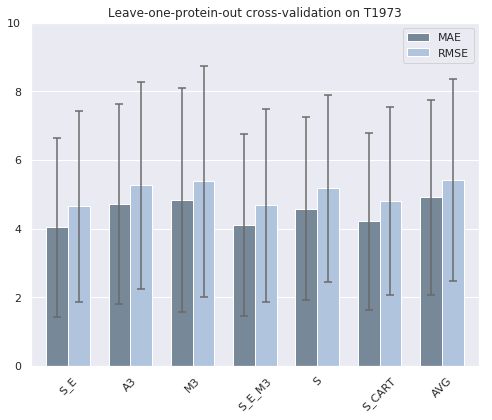

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Leave-one-protein-out cross-validation on T1973",saveloc=data_target_location+"ppcv_performance_NEW.png", fig_size=(7,6), fig_lim=(0,10))

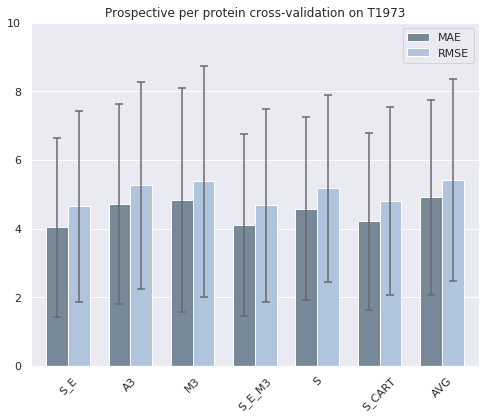

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Leave-one-protein-out cross-validation on T1973",saveloc=data_target_location+"ppcv_performance_NEW.png", fig_size=(7,6), fig_lim=(0,10))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)
results = results.round(3)

In [0]:
results

MAE   RMSE  MAE_std  RMSE_std
S_E     4.037  4.652    2.600     2.787
A3      4.713  5.258    2.906     3.024
M3      4.827  5.379    3.266     3.360
S_E_M3  4.102  4.681    2.641     2.807
S       4.579  5.172    2.665     2.731
S_CART  4.210  4.811    2.586     2.734
AVG     4.909  5.417    2.853     2.946

In [0]:
results.to_csv(data_target_location+"ppcv_performance_table.csv")

### Weighted Results (weighted by the number of mutants in the holdout set)

In [0]:
model = ["S_E","A3","M3","S_E_M3","S","S_CART","AVG"]
value = [[3.6130589506614204,4.482813606726061],
         [4.234991462645863,5.104671438269491],
         [4.33763789830654,5.219781677659155],
         [3.448979575132772,4.2405786772794665],
         [4.091008571072409,5.009743420807611],
         [3.798284083920712,4.6866378745656245],
         [4.396683336063589,5.256157466190632]
        ]
std = [[1.8538583747657709,1.9925575546153285],
      [1.9601433562090178,2.133625592264799],
      [2.104209782463362,2.2381746057051033],
      [1.7922295221128801,1.9433489920901108],
      [1.9313216800694606,2.029072817958757],
      [1.874305266702776,1.9559545390561304],
      [1.818862696115409,1.9933304129640528]]
measure = ["MAE","RMSE"]

values_df = pd.DataFrame(value)
values_df.columns=measure
values_df.index=model

std_df = pd.DataFrame(std)
std_df.columns=measure
std_df.index=model

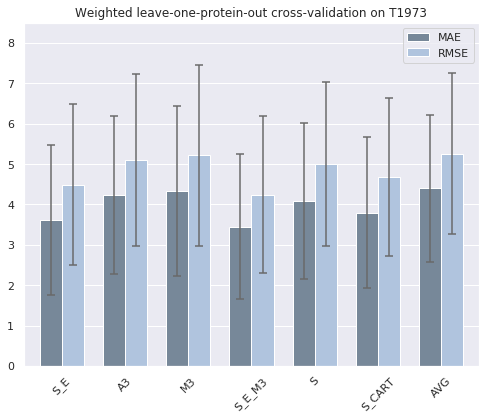

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Weighted leave-one-protein-out cross-validation on T1973",saveloc=data_target_location+"weighted_ppcv_performance_NEW.png", fig_size=(7,6), fig_lim=(0,8.5))

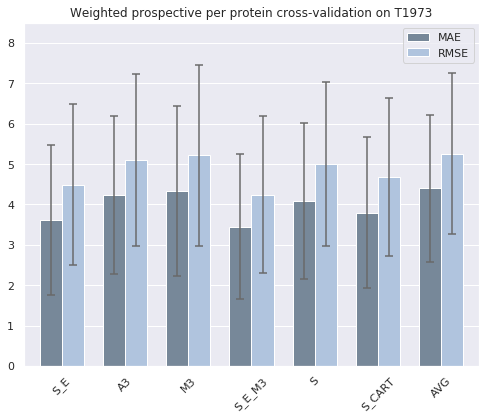

In [0]:
plot_results_bar_err(results_df=values_df,std_df=std_df,title="Weighted prospective per protein cross-validation on T1973",saveloc=data_target_location+"weighted_ppcv_performance.png", fig_size=(7,6), fig_lim=(0,8.5))

In [0]:
std_df.columns = list(map(lambda x: x+"_std",std_df.columns))
results = pd.concat([values_df,std_df], axis=1)
results = results.round(3)

In [0]:
results

MAE   RMSE  MAE_std  RMSE_std
S_E     3.613  4.483    1.854     1.993
A3      4.235  5.105    1.960     2.134
M3      4.338  5.220    2.104     2.238
S_E_M3  3.449  4.241    1.792     1.943
S       4.091  5.010    1.931     2.029
S_CART  3.798  4.687    1.874     1.956
AVG     4.397  5.256    1.819     1.993

In [0]:
results.to_csv(data_target_location+"weighted_ppcv_performance_table.csv")